# 2. Principle Component Analysis

### Import
Importing useful libraries

In [ ]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from math import log10

### Data Loading

Loads MNIST training and test data from CSV files, then separates them into feature matrices (X) and label vectors (y).


In [ ]:
def load_mnist_data(train_file, test_file):
    train_data = np.loadtxt(train_file, delimiter=',', skiprows=1)
    test_data = np.loadtxt(test_file, delimiter=',', skiprows=1)
    X_train = train_data[:, 1:]
    y_train = train_data[:, 0]
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0]
    return X_train, y_train, X_test, y_test

This code defines two functions to load CIFAR-10 data. `load_cifar_batch` loads a single batch of CIFAR-10 data from a file, returning the image data and labels. `load_cifar10_data` iterates over the 5 training batches, loading and combining their data and labels, and then loads the test batch. It returns arrays for training data, training labels, test data, and test labels.


In [ ]:
def load_cifar_batch(batch_filename):
    with open(batch_filename, 'rb') as file:
        batch_data = pickle.load(file, encoding='latin1')
    return batch_data['data'], batch_data['labels']
def load_cifar10_data(data_dir):
    data = []
    labels = []
    for batch in range(1, 6):
        batch_filename = os.path.join(data_dir, f'data_batch_{batch}')
        batch_data, batch_labels = load_cifar_batch(batch_filename)
        data.append(batch_data)
        labels.extend(batch_labels)
    data = np.concatenate(data, axis=0)
    labels = np.array(labels)
    test_batch_filename = os.path.join(data_dir, 'test_batch')
    test_data, test_labels = load_cifar_batch(test_batch_filename)

    return data, labels, test_data, test_labels

Data loading main function

In [ ]:
train_file = '/content/drive/MyDrive/Colab Notebooks/MNIST_CSV/mnist_train.csv'
test_file = '/content/drive/MyDrive/Colab Notebooks/MNIST_CSV/mnist_test.csv'
data_dir = '/content/drive/MyDrive/Colab Notebooks/cifar-10-python/cifar-10-batches-py'
mnist_dataset = load_mnist_data(train_file, test_file)
cifar_dataset = load_cifar10_data(data_dir)

###2.1.1 Metrics Calculation Functions
- `calculate_mse`: Computes the Mean Squared Error (MSE) by flattening two arrays and finding the average squared difference between corresponding elements.
- `calculate_psnr`: Computes the Peak Signal-to-Noise Ratio (PSNR) using the MSE, returning a high value (100) if MSE is zero; otherwise, it calculates PSNR based on a formula involving MSE.


In [ ]:
def calculate_mse(original, reconstructed):
    original_flat = original.flatten()
    reconstructed_flat = reconstructed.flatten()
    mse = np.mean((original_flat - reconstructed_flat) ** 2)
    return mse

def calculate_psnr(original, reconstructed):
    mse = calculate_mse(original, reconstructed)
    if mse == 0:
        return 100
    return 20 * log10(255.0 / np.sqrt(mse))

### 2.1 PCA Implementation

#### 2.1.1 `standardize_data(X)`
Centers data by subtracting the mean of each feature, returning the centered data and mean.


In [ ]:
def standardize_data(X):
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    return X_centered, mean

#### 2.1.2 PCA Computation
`compute_pca_eigen(X, n_components)`
1. **Covariance Calculation**: Compute the covariance matrix of `X`.
2. **Eigen Decomposition**: Perform eigen decomposition on the covariance matrix.
3. **Sort and Select Components**: Sort eigenvectors by their eigenvalues (descending), then retain the top `n_components`.
4. **Explained Variance Ratio**: Calculate the variance ratio for each selected component.


In [ ]:
def compute_pca_eigen(X, n_components):
    covariance_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvectors = eigenvectors[:, :n_components]
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    return eigenvectors, explained_variance_ratio

#### 2.1.3 Reconstruction Images from PCA Components
`reconstruct_images(X, components, mean)`
Projects `X` onto principal components, reverses the projection, and adds the mean to produce reconstructed data.


In [ ]:
def reconstruct_images(X, components, mean):
    X_projected = np.dot(X, components)
    X_reconstructed = np.dot(X_projected, components.T)
    X_reconstructed += mean
    return X_reconstructed

### 2.2 Analysis and Visualization

#### 2.2.1 Visualisation and Analysis
Original and Reconstructed Image Visualization with MSE and PSNR
`plot_images` displays 10 original and reconstructed images side-by-side for MNIST or CIFAR-10, using indices specific to each dataset. For each image, it calculates and prints Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) metrics, along with average values, helping analyze reconstruction quality across varying PCA components.


In [ ]:
def plot_images(original, reconstructed, dataset, pca_components, indices=range(10)):
    fig, ax = plt.subplots(2, len(indices), figsize=(15, 5))
    mse_list = []
    psnr_list = []
    MNIST_indices = [0, 2, 4, 6, 1, 10, 12, 14, 16, 3]
    CIFAR_indices = [29, 4, 6, 9, 3, 27, 0, 7, 8, 1]
    for i in range(10):
        if dataset == 'MNIST':
            ax[0, i].imshow(original[MNIST_indices[i]].reshape(28, 28), cmap='gray')
            ax[1, i].imshow(reconstructed[MNIST_indices[i]].reshape(28, 28), cmap='gray')
            mse = calculate_mse(original[MNIST_indices[i]], reconstructed[MNIST_indices[i]])
            psnr = calculate_psnr(original[MNIST_indices[i]], reconstructed[MNIST_indices[i]])
        else:
            ax[0, i].imshow(original[CIFAR_indices[i]].reshape(32, 32, 3).astype(np.uint8))
            ax[1, i].imshow(reconstructed[CIFAR_indices[i]].reshape(32, 32, 3).astype(np.uint8))
            mse = calculate_mse(original[CIFAR_indices[i]],reconstructed[CIFAR_indices[i]])
            psnr = calculate_psnr(original[CIFAR_indices[i]],reconstructed[CIFAR_indices[i]])
        ax[0, i].set_title(f"Original {i+1}")
        ax[0, i].axis('off')
        ax[1, i].set_title(f"Reconstructed {i+1}")
        ax[1, i].axis('off')

        mse_list.append(mse)
        psnr_list.append(psnr)

    plt.tight_layout()
    plt.show()

    print(f"Using {pca_components} components:")
    print("MSE for images:", mse_list)
    print("PSNR for images:", psnr_list)
    print("Average MSE:", np.mean(mse_list))
    print("Average PSNR:", np.mean(psnr_list))


#### PCA
Performs PCA on a dataset by standardizing training data, computing principal components, reconstructing images, and visualizing original vs. reconstructed images. Takes dataset, number of components, and dataset name as inputs.


In [ ]:
def PCA(dataname, dataset, pca_components = 50):
    X_train, y_train, X_test, y_test = dataset
    X_train_standardized, mean_train = standardize_data(X_train)
    components, explained_variance_ratio = compute_pca_eigen(X_train_standardized, pca_components)
    X_train_reconstructed = reconstruct_images(X_train_standardized, components, mean_train)
    plot_images(X_train, X_train_reconstructed, dataname, pca_components)

#### 2.2.2.a Running PCA for differenct number of PCA components


##### For MNIST dataset

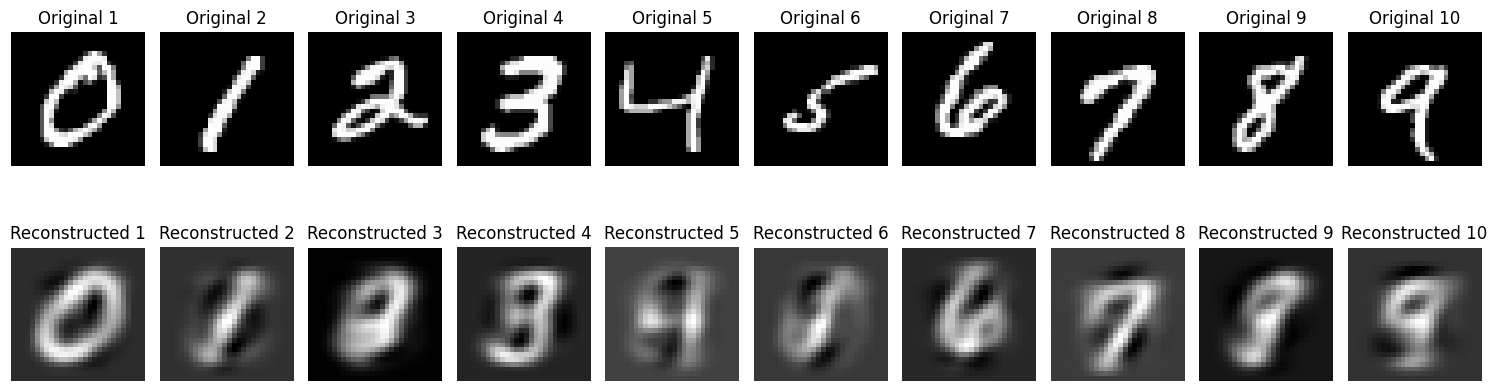

Using 10 components:
MSE for images: [1808.5059208359, 1186.0216106123405, 3201.1476641077493, 1730.533888055605, 2900.9185142240117, 2362.261554465553, 2146.39674439535, 1427.4866536294596, 1956.9079108536434, 2211.7943920791463]
PSNR for images: [15.557604259388366, 17.389877584465943, 13.0777465291308, 15.749002526139847, 13.505448310724475, 14.397523789484485, 14.813703599312952, 16.585083043928794, 15.215099719749146, 14.68335608278526]
Average MSE: 2093.197485325876
Average PSNR: 15.097444544511003


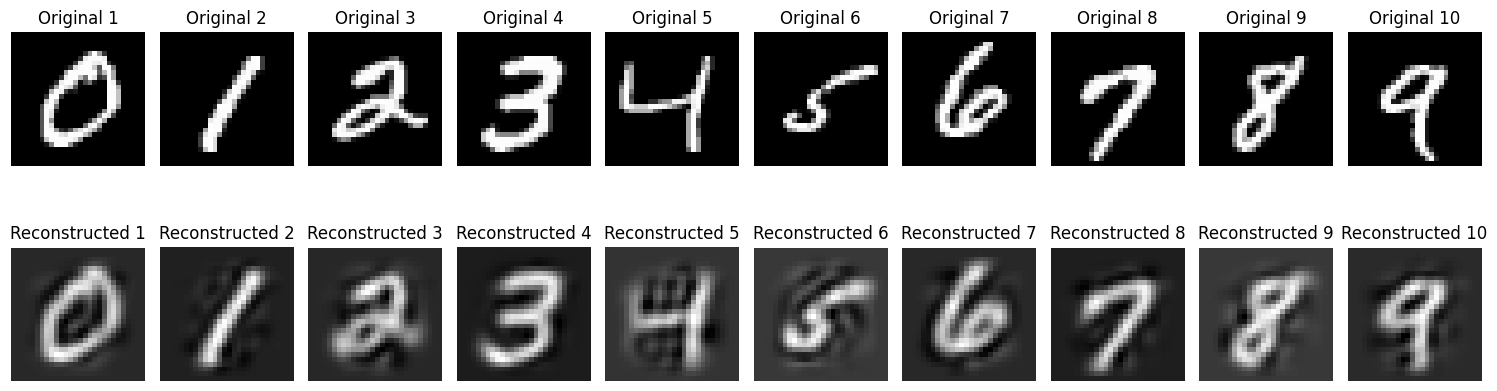

Using 50 components:
MSE for images: [636.6627047107249, 286.78041654301865, 957.2680776957926, 543.7794974060544, 1590.6847291140718, 857.3645922745479, 949.874024851481, 476.14634708743864, 596.8722081855797, 852.4538333202437]
PSNR for images: [20.091709509486783, 23.555308696520928, 18.320467842609347, 20.776575318924017, 16.114962490867327, 18.79914816959574, 18.354143491997167, 21.35339904021267, 20.371990033075154, 18.824094928247032]
Average MSE: 774.7886431188953
Average PSNR: 19.656179952153614


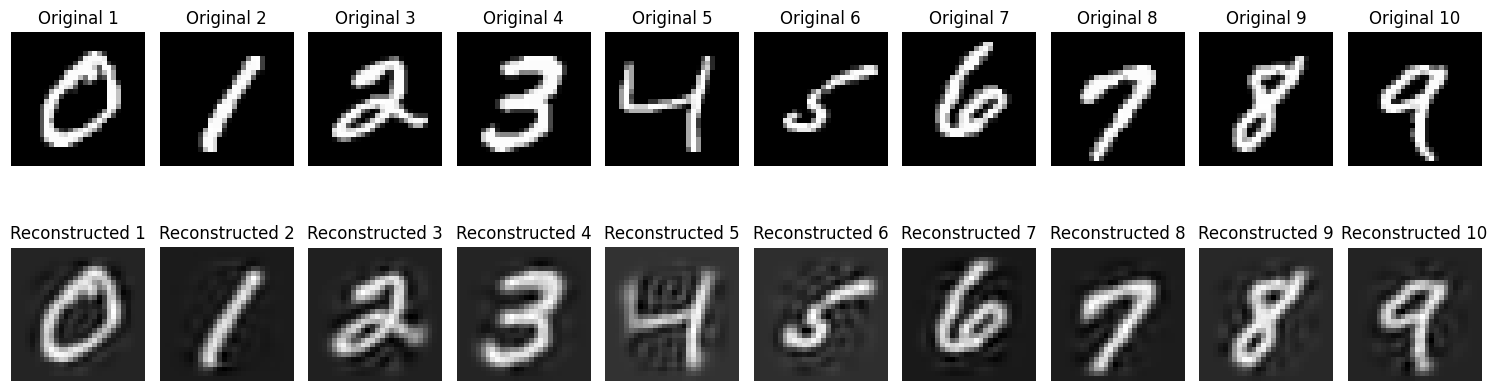

Using 100 components:
MSE for images: [277.79679066048493, 183.44402081563462, 421.08224467806576, 351.9064888257684, 903.9641029035223, 417.60860775274415, 343.9601848375465, 308.7466999629481, 227.72979104720508, 382.7808229959774]
PSNR for images: [23.693531367683043, 25.49576799963159, 21.88713431489701, 22.666530859757597, 18.569291762116357, 21.923109190993006, 22.765721872094655, 23.234780365290657, 24.556605132079273, 22.301301890140124]
Average MSE: 381.90197544798974
Average PSNR: 22.709377475468337


In [ ]:
PCA("MNIST", mnist_dataset , pca_components= 10)
PCA("MNIST", mnist_dataset , pca_components= 50)
PCA("MNIST", mnist_dataset , pca_components= 100)

##### For CIFAR-10 dataset


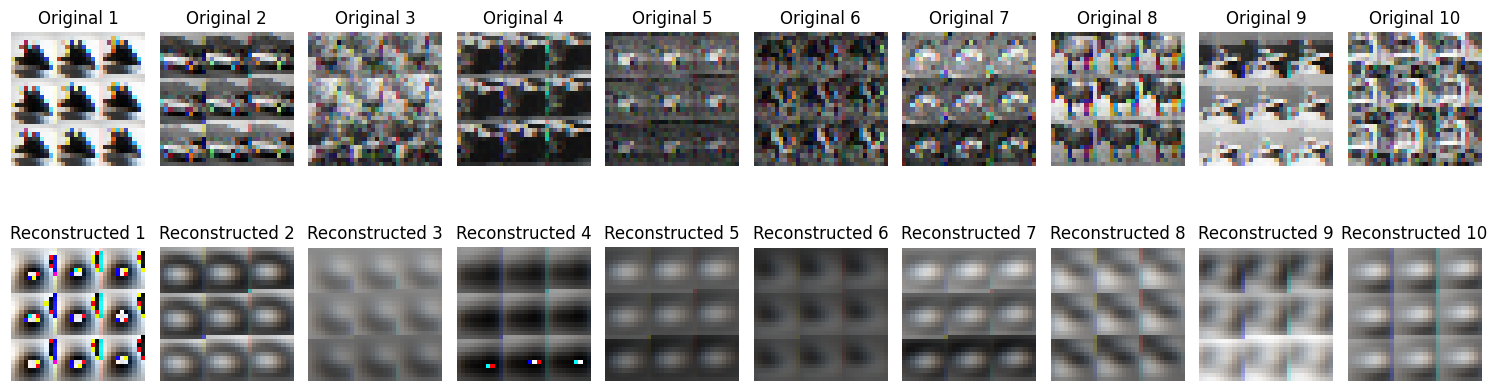

Using 10 components:
MSE for images: [2060.653645660526, 1722.7936310060097, 2195.849727890729, 1605.698050809573, 580.2716903610786, 1256.220173934933, 996.8409467609732, 2346.629977106301, 1826.3509495698047, 2518.7983380693186]
PSNR for images: [14.99075359102756, 15.768471033172005, 14.714777448443602, 16.074164806950524, 20.494489776545322, 17.140145973067273, 18.144544918787524, 14.42635746586728, 15.514961261051933, 14.118869627900379]
Average MSE: 1711.0107131169248
Average PSNR: 16.13875359028134


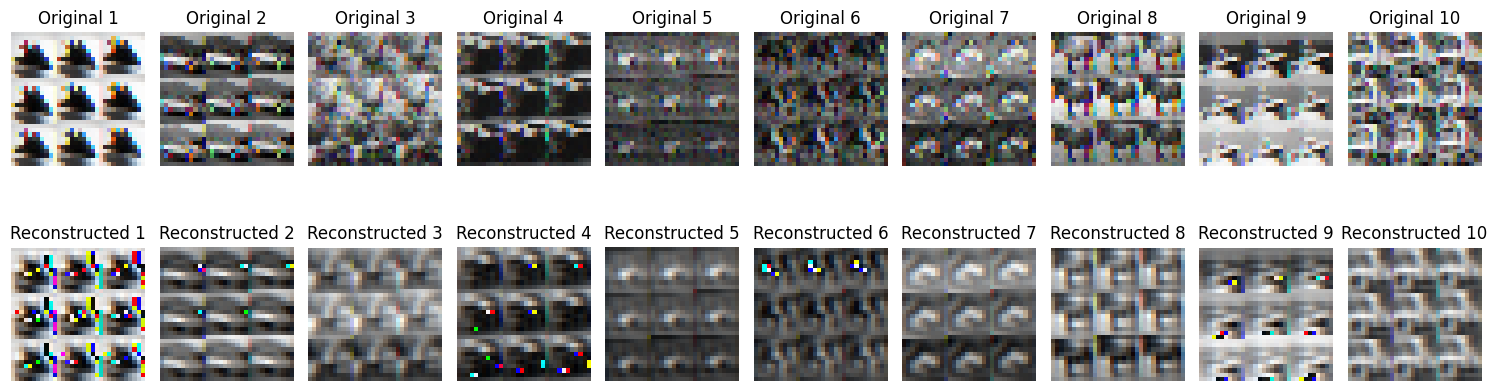

Using 50 components:
MSE for images: [916.9832445607849, 750.2446391174216, 854.7881155503479, 766.2765108604308, 260.906529687403, 647.7883393425326, 584.9345793218843, 1083.5217963188336, 792.4426634264856, 1363.7441466370312]
PSNR for images: [18.507189607063673, 19.378774600166583, 18.81221885497994, 19.286948477998706, 23.965954125774957, 20.01647234737396, 20.459730647485976, 17.782427087784928, 19.141125118813534, 16.7834746131455]
Average MSE: 802.1630564823156
Average PSNR: 19.413431548058774


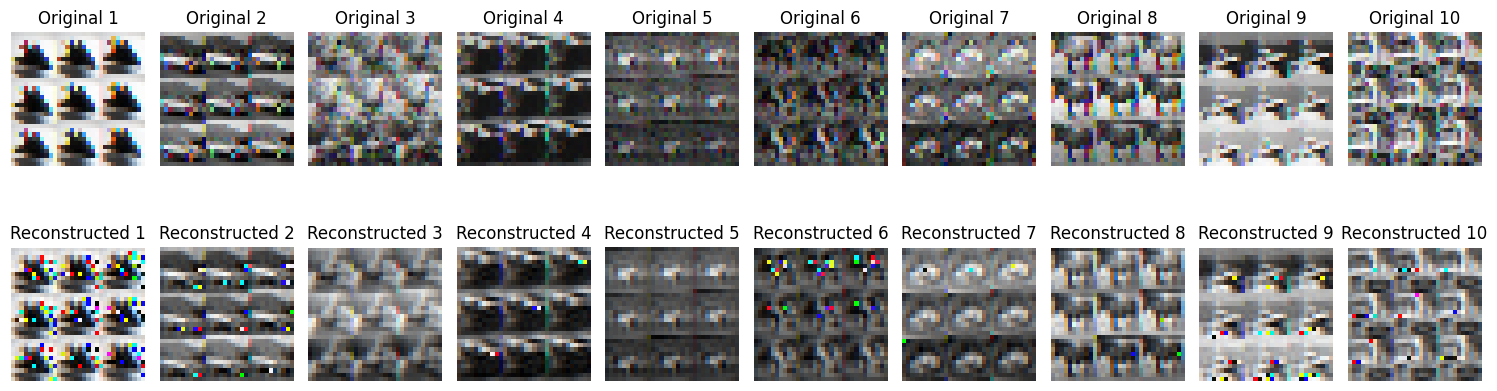

Using 100 components:
MSE for images: [451.119229499667, 498.67821483912695, 677.4155006094206, 387.39990253332707, 156.15240593370342, 438.05650714189704, 436.458277988474, 613.6748741452938, 383.51962130569774, 820.6719728377308]
PSNR for images: [21.587890210510665, 21.15259964740606, 19.822252309270016, 22.24920853749773, 26.19531680814779, 21.715502248911434, 21.731376260116605, 20.251420186552444, 22.2929277300845, 18.98910758990614]
Average MSE: 486.31465068343385
Average PSNR: 21.598760152840338


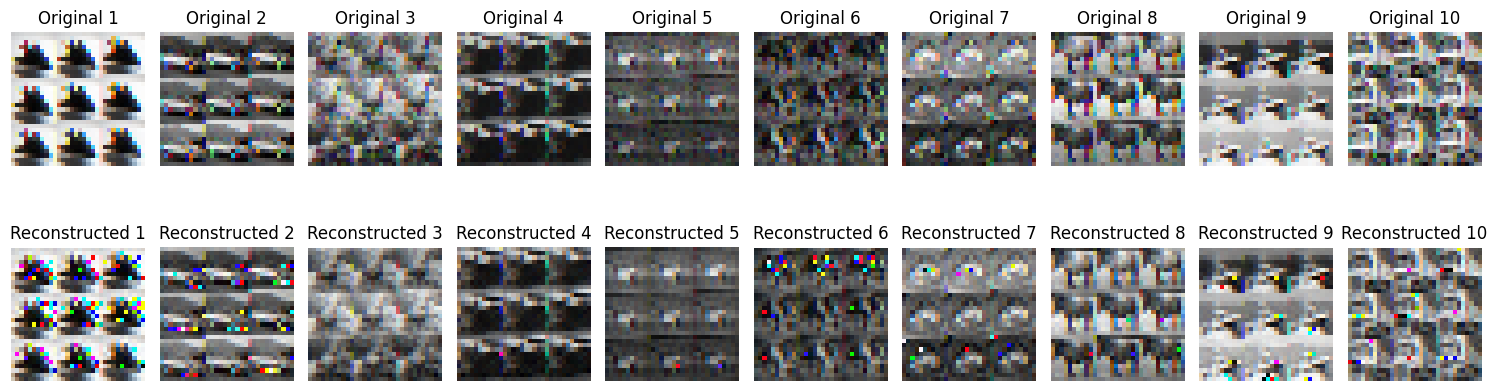

Using 200 components:
MSE for images: [176.24049195035505, 233.6736364404967, 406.76121630046913, 171.8082545343234, 95.04740335795127, 230.65217649470102, 247.6766924654439, 319.68549741316946, 168.9705784780089, 432.7896623289676]
PSNR for images: [25.669746644520124, 24.444706437442868, 22.037408235731135, 25.780363351760187, 28.351401041874084, 24.501228037871464, 24.19195221500115, 23.083574259922045, 25.852692699643992, 21.76803482260858]
Average MSE: 248.33056097638865
Average PSNR: 24.568110774637564


In [ ]:
PCA("CIFAR", cifar_dataset, pca_components= 10)
PCA("CIFAR", cifar_dataset, pca_components= 50)
PCA("CIFAR", cifar_dataset, pca_components= 100)
PCA("CIFAR", cifar_dataset, pca_components= 200)

## 2.2.2 Comparative Performance of Gray-scale (MNIST) and Color (CIFAR-10) Image Reconstructions Using PCA

## Results and Analysis

### 1. **Effect of Number of Components on Reconstruction Quality**
As the number of PCA components increases, the reconstruction quality improves, as more variance in the data is captured. The table below shows the MSE and PSNR for both MNIST and CIFAR-10 reconstructions with varying numbers of components.

| **Dataset**   | **Components** | **MSE**    | **PSNR (dB)** |
|---------------|----------------|-----------|---------------|
| MNIST     | 10             | 2093     | 15.09          |
| MNIST     | 50            | 774     | 19.65          |
| MNIST     | 100            | 381      | 22.7         |
| CIFAR-10  | 10         | 1711    | 16.1          |
| CIFAR-10  | 50        | 802    | 19.4          |
| CIFAR-10  | 100        | 486     | 21.5          |

- **MNIST (Gray-scale)**: The MSE decreases and PSNR increases with the number of components. The reconstruction quality is relatively high even with fewer components, as the data is less complex.
  
- **CIFAR-10 (Color)**: For CIFAR-10, the MSE is higher compared to MNIST, and the PSNR is lower, which indicates that color images require more components for good reconstruction. This is expected because color images have more complex features compared to gray-scale images.

### 2. **Visual Comparison**

In the case of MNIST, the reconstruction quality is quite good even with fewer components. For CIFAR-10, however, the reconstructions are more blurry, which is a result of the increased complexity of color images.

### 3. **Comparison of Reconstruction Performance**
- **Gray-scale (MNIST)**: The reconstruction quality improves rapidly with the number of components. Even with 100 components, the reconstructed images are visually close to the original, with only slight details lost.
  
- **Color (CIFAR-10)**: Color images require significantly more components to achieve good reconstruction. The performance improves at a slower rate compared to MNIST, and even with 200 components, some details are lost, especially for fine textures and edges.

### 4. **Compression Ratio vs. Image Quality**
The compression ratio can be defined as the ratio of the number of original features to the number of components used in PCA. As we increase the number of components, the compression ratio decreases, leading to higher reconstruction quality but less compression.

| **Dataset**   | **Compression Ratio (50 Components)** | **MSE**    | **PSNR (dB)** |
|---------------|--------------------------------------|-----------|---------------|
| MNIST   | 784/100 = 7.84                       | 381     | 22.7          |
| CIFAR-10 | 3072/100 = 30.72                    | 486     | 21.5          |

### Conclusion

- **Gray-scale MNIST**: The PCA-based reconstruction yields excellent quality even with a small number of components. The MSE is low, and the PSNR is high even for modest compression ratios.
  
- **Color CIFAR-10**: The reconstruction quality for color images is lower than that of gray-scale images, and more components are needed to achieve high-quality reconstruction. The MSE remains higher, and PSNR is lower, even with more components.


---

